# Characterising EPIC 201367296 with lightkurve

The star  EPIC 201367296 is a main sequence star observed in Campaign 1 of the K2 mission, and one of the stars analysed in the [Chaplin et al. 2015](https://arxiv.org/abs/1507.01827) first analysis of K2 main sequence targets.

Unlike many *Kepler* main sequence stars that have been studied with asteroseismology, we only have one K2 campaign (3 months) worth of data for this star. This makes our analysis a little more difficult, as we'll have a poorer time resolution.

This notebook won't have as much commentary. Check out the example notebook on KIC 10963064 (aka Rudy) for a more in-depth introduction to the tools.

You can learn more and find tutorials at https://docs.lightkurve.org/ !

This notebook, along with others that deal with asteroseismic analysis of Kepler and TESS targets, can be found on [this GitHub repository](https://github.com/ojhall94/TASC5_lightkurve).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import lightkurve as lk

In [2]:
target = 'EPIC 201367296'

datalist = lk.search_lightcurvefile(target, cadence='short')
datalist

SearchResult containing 1 data products.

 target_name       productFilename                   description              distance
------------- -------------------------- ------------------------------------ --------
ktwo201367296 ktwo201367296-c01_slc.fits Lightcurve Short Cadence (KSC) - C01      0.0

In [3]:
lc = datalist.download().PDCSAP_FLUX.normalize().remove_nans().flatten().remove_outliers()

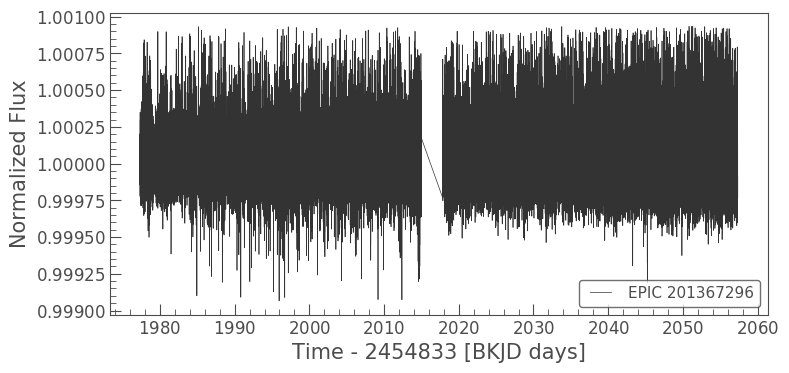

In [4]:
lc.plot()

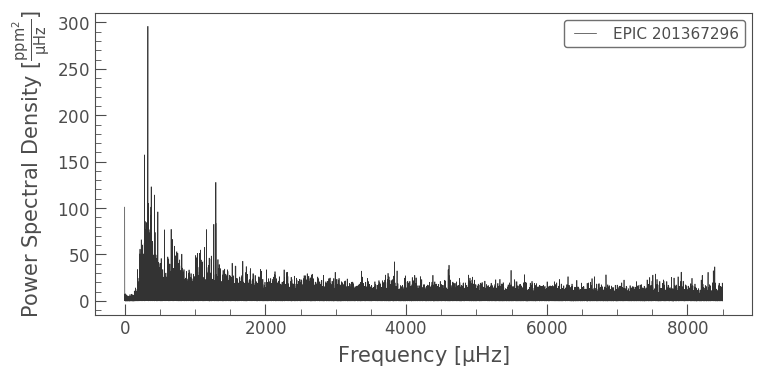

In [5]:
pg = lc.to_periodogram(normalization='psd')
pg.plot()

Let's zoom in on the relevant region.

In [6]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=800, maximum_frequency=2000)

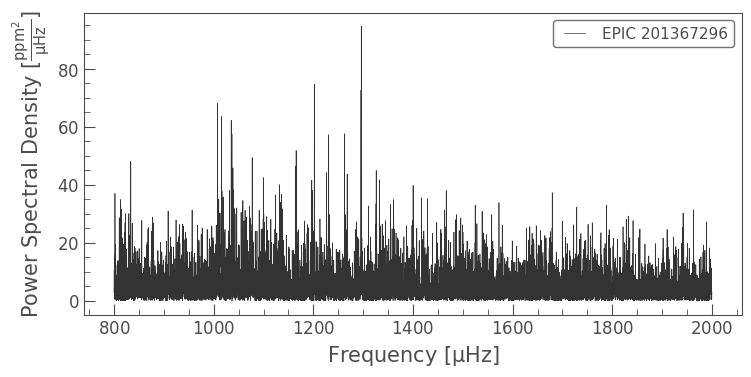

In [7]:
pg.plot()

Just flattening the periodogram before going into seismology tools...

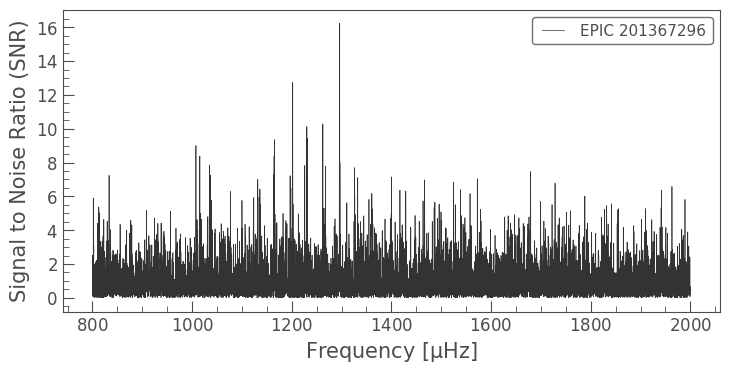

In [8]:
snr = pg.flatten()
snr.plot()

Lets throw our seismology tools at this noiser spectrum and see how they do!

In [9]:
butler = snr.to_seismology()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12762deb8>,
      dtype=object)

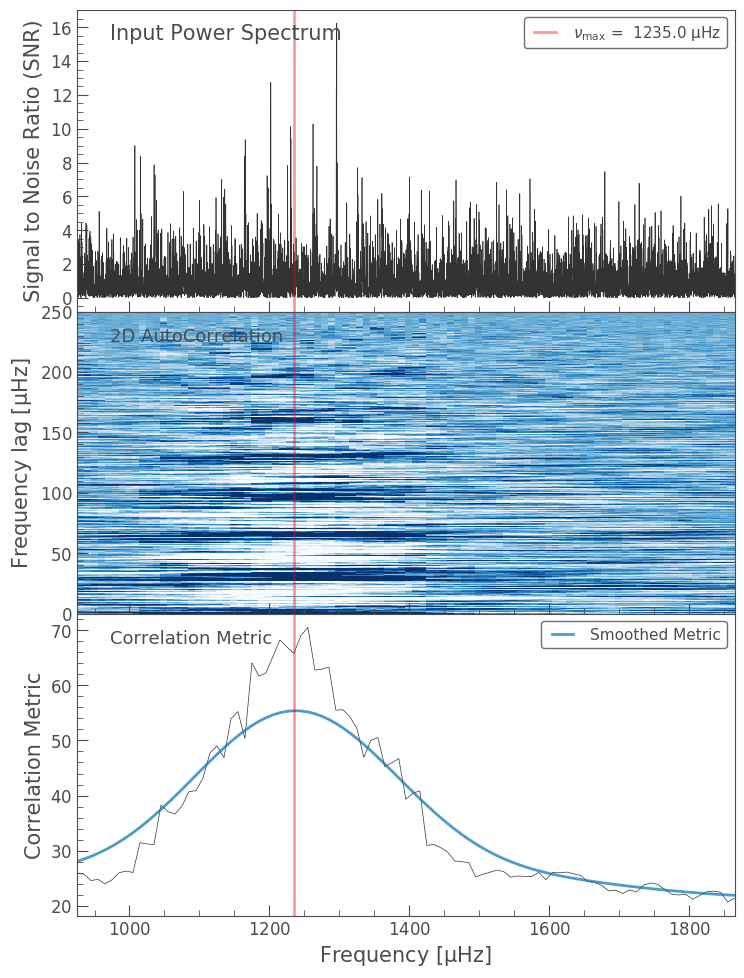

In [10]:
butler.estimate_numax()
butler.diagnose_numax()

Okay, so globally this looks alright, but the resolution is pretty poor. Let's try and improve this by changing the central frequencies (`numaxs`) at which the autocorrelation is evaluated. We'll decrease the spacing, so that the resolution increases.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11cbf4a90>,
      dtype=object)

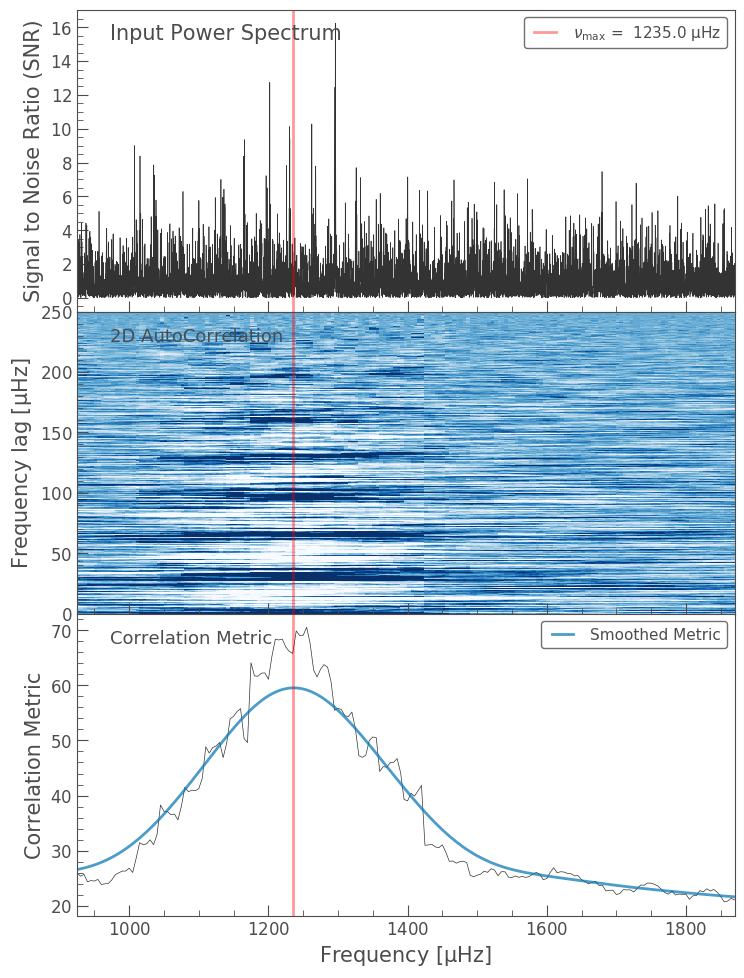

In [11]:
butler.estimate_numax(spacing=5)
butler.diagnose_numax()

Now let's see what the $\Delta\nu$ estimation looks like.

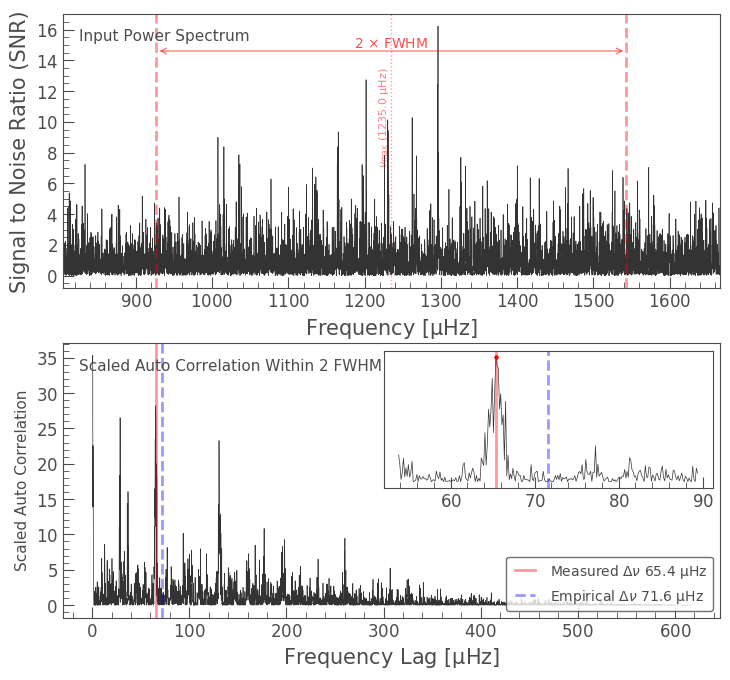

In [12]:
butler.estimate_deltanu()
butler.diagnose_deltanu()

Yikes, that ACF looks super noisy, but we're getting strong repeating peaks at least, and only one close to the empirical estimate for $\Delta\nu$. Thats good enough for me! Let's calculate some stellar parameters, and see how they fare against those in Chaplin et al. 2015.

In [13]:
teff = 5695
mass = butler.estimate_mass(teff)

In [14]:
radius = butler.estimate_radius(teff)


In [15]:
logg = butler.estimate_logg(teff)

In [16]:
print('True numax: {} +- {} vs {:.2f} microHz'.format(1176, 58., butler.numax.value))
print('True deltanu: {} +- {} vs {:.2f} microHz'.format(65.7, 0.7, butler.deltanu.value))
print('True Radius: {} +- {} vs {:.2f} Rsol'.format(1.71, 0.03, radius.value))
print('True Mass: {} +- {} vs {:.2f} Msol'.format(1.14, 0.05, mass.value))
print('True Logg: {} +- {} vs {:.2f} dex'.format(4.032, 0.008, logg.value))

True numax: 1176 +- 58.0 vs 1235.00 microHz
True deltanu: 65.7 +- 0.7 vs 65.39 microHz
True Radius: 1.71 +- 0.03 vs 1.69 Rsol
True Mass: 1.14 +- 0.05 vs 1.14 Msol
True Logg: 4.032 +- 0.008 vs 4.04 dex


Looks like they're all in the right ballpark, neat! Especially the lock on $\Delta\nu$ is good, given the signal-to-noise. The exactly location of $\nu_{\rm max}$ is harder to get right given the noise, but we've recovered it well enough to get a good grasp on the remaining stellar parameters, which is reassuring.

Let's plot a quick echelle diagram for good measure.

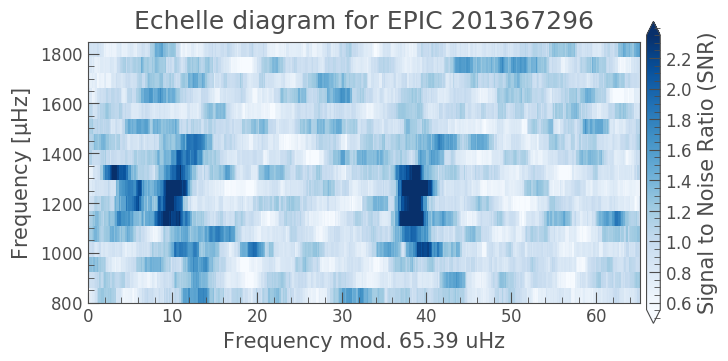

In [17]:
butler.plot_echelle(smooth_filter_width=3.)

In [18]:
sys.exit()

NameError: name 'sys' is not defined

In [ ]:
deltanu=None
numax=None

minimum_frequency=None
maximum_frequency=None

smooth_filter_width=.1

scale='linear'
cmap='Blues'

In [ ]:
import astropy.units as u
import numpy as np

In [ ]:
        numax = butler._validate_numax(numax)
        deltanu = butler._validate_deltanu(deltanu)

        if smooth_filter_width:
            freq = butler.periodogram.smooth(filter_width=smooth_filter_width).frequency  # Makes code below more readable
            power = butler.periodogram.smooth(filter_width=smooth_filter_width).power     # Makes code below more readable
        else:
            freq = butler.periodogram.frequency  # Makes code below more readable
            power = butler.periodogram.power     # Makes code below more readable

        fmin = freq[0]
        fmax = freq[-1]

        # Check for any superfluous input
        if (numax is not None) & (any([a is not None for a in [minimum_frequency, maximum_frequency]])):
            warnings.warn("You have passed both a numax and a frequency limit. "
                          "The frequency limit will override the numax input.",
                          LightkurveWarning)

        # Ensure input numax is in the correct units (if there is one)
        if numax is not None:
            numax = u.Quantity(numax, freq.unit).value
            if numax > freq[-1].value:
                raise ValueError("You can't pass in a numax outside the"
                                "frequency range of the periodogram.")

            fwhm = lk.utils.get_fwhm(butler.periodogram, numax)

            fmin = numax - 2*fwhm
            if fmin < 0.:
                fmin = 0.

            fmax = numax + 2*fwhm
            if fmax > freq[-1].value:
                fmax = freq[-1].value

        # Set limits and set them in the right units
        if minimum_frequency is not None:
            fmin =  u.Quantity(minimum_frequency, freq.unit).value
            if fmin > freq[-1].value:
                raise ValueError("You can't pass in a limit outside the"
                                 "frequency range of the periodogram.")

        if maximum_frequency is not None:
            fmax = u.Quantity(maximum_frequency, freq.unit).value
            if fmax > freq[-1].value:
                raise ValueError("You can't pass in a limit outside the"
                                 "frequency range of the periodogram.")

        # Make sure fmin and fmax are Quantities or code below will break
        fmin = u.Quantity(fmin, freq.unit)
        fmax = u.Quantity(fmax, freq.unit)

        # Add on 1x deltanu so we don't miss off any important range due to rounding
        if fmax < freq[-1] - 1.5*deltanu:
            fmax += deltanu
        
        # Check fmin isn't below the lowest frequency in the periodogram
        if fmin < freq[0]:
            fmin = freq[0]

        fs = np.median(np.diff(freq))
        x0 = int(freq[0] / fs)

        ff = freq[int(fmin/fs)-x0:int(fmax/fs)-x0] # Selected frequency range
        pp = power[int(fmin/fs)-x0:int(fmax/fs)-x0] # Power range

        n_rows = int((ff[-1]-ff[0])/deltanu) # Number of stacks to use
        n_columns = int(deltanu/fs)          # Number of elements in each stack

        # Reshape the power into n_rows of n_columns
        ep = np.reshape(pp[:(n_rows*n_columns)], (n_rows, n_columns))

        if scale=='log':
            ep = np.log10(ep)

        #Reshape the freq into n_rowss of n_columnss & create arays
        ef = np.reshape(ff[:(n_rows*n_columns)],(n_rows,n_columns))
        x_f = ((ef[0,:]-ef[0,0]) % deltanu)
        y_f = (ef[:,0])

        #Plot the echelle diagram
        with plt.style.context(lk.MPLSTYLE):
            fig, ax = plt.subplots()
            extent = (x_f[0].value, x_f[-1].value, y_f[0].value, y_f[-1].value)
            figsize = plt.rcParams['figure.figsize']
            a = figsize[1] / figsize[0]
            b = (extent[3] - extent[2]) / (extent[1])
            vmin = np.nanpercentile(ep.value, 1)
            vmax = np.nanpercentile(ep.value, 99)
            im = ax.imshow(ep.value, cmap=cmap, aspect=a/b, origin='lower',
                      extent=extent, vmin=vmin, vmax=vmax)
            cbar = plt.colorbar(im, ax=ax, extend='both', pad=.01)

In [ ]:
            extent = (x_f[0].value, x_f[-1].value, y_f[0].value, y_f[-1].value)


In [ ]:
        ff = freq[int(fmin/fs)-x0:int(fmax/fs)-x0] # Selected frequency range


In [ ]:
int(fmin/fs)

In [ ]:
fmin

In [ ]:
freq[0]

In [ ]:
freq[int(fmin/fs)-int(freq[0]/fs)]